<a href="https://colab.research.google.com/github/qvu3/portfolio/blob/main/fcc_bikes_regression_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import tensorflow as tf


from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


Source:

Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date","Holiday","Seasons"], axis=1)

In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"]== "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"],axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label],df["bike_count"])
  plt.title(label)
  plt.ylabel("bike count at Noon")
  plt.xlabel(label)
  plt.show()

In [ ]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


<h2><b>Train/Valid/Test dataset

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(len(df)*0.6), int(len(df)*0.8)])

In [ ]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((x,y))

  return data, x, y 

In [ ]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [ ]:
print(temp_reg.coef_, temp_reg.intercept_)

[[18.75374801]] [371.7896489]


In [ ]:
temp_reg.score(x_test_temp, y_test_temp)

0.32726496556618223

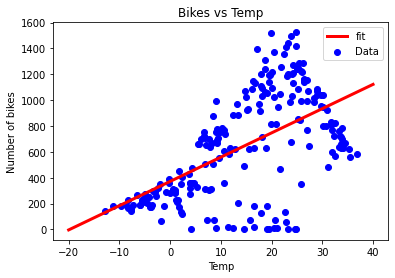

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()


<h2><b>Multiple Linear Regression

In [ ]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(len(df)*0.6), int(len(df)*0.8)])
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=train.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels=val.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=test.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [ ]:
all_reg.score(x_test_all, y_test_all)

0.495981067625472

<h2><b>Regression with NN

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1,1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

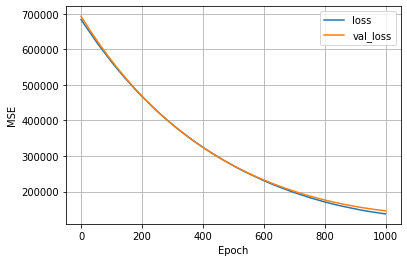

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


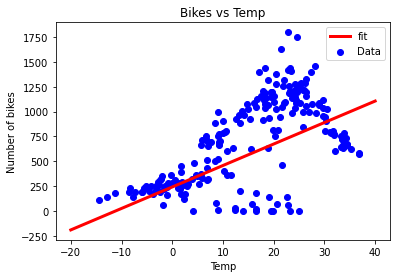

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

<b>NN Single Input

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))
single_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])

single_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [ ]:
history = single_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

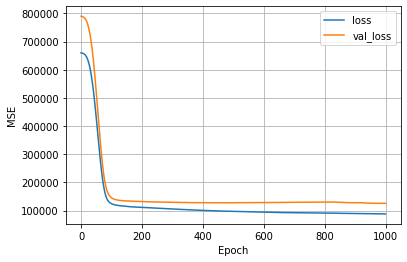

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


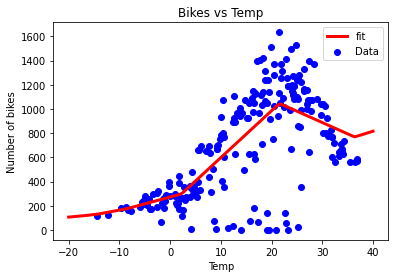

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, single_nn_model.predict(np.array(x).reshape(-1,1)), label="fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

<h2><b>NN Multi-inputs

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,),axis=-1)
all_normalizer.adapt(x_train_all)


In [ ]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])

all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [ ]:
history = all_nn_model.fit(
    x_train_all, y_train_all,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_all, y_val_all)
)

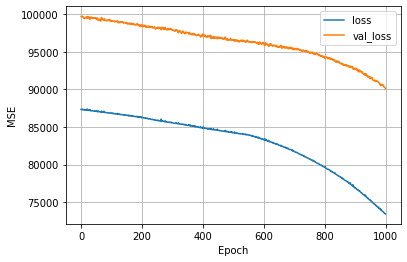

In [ ]:
plot_loss(history)

In [ ]:
# calculate MSE for both linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = all_nn_model.predict(x_test_all)

3/3 [==============================] - 0s 3ms/step


In [ ]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [ ]:
MSE(y_pred_lr,y_test_all)

114761.03581072105

In [ ]:
MSE(y_pred_nn,y_test_all)

109101.38712243781

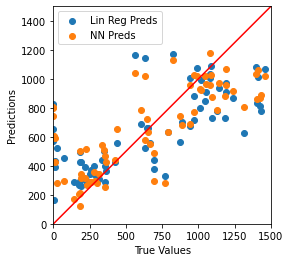

In [ ]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label='Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label='NN Preds')
plt.ylabel("Predictions")
plt.xlabel("True Values")
lims = [0, 1500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims,c="red")
plt.legend()
plt.show()